## Задание 1. Введение в анализ временных рядов

## Цель задания:
### 1. Получить  навыки работы с финансовыми временными рядами
### 2. Провести проверку временного ряда на стационарность 
### 3. Построить модель ARIMA-GARCH
### 4. Исследовать модель CAPM

## 1.Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import statsmodels.tsa as tsa # анализ временных рядов
import statsmodels.graphics.tsaplots as tsaplots # визуализация параметров временных рядов
import statsmodels.formula.api as smf # регрессионная модель
import statsmodels.stats.outliers_influence  # регрессионные тесты
import statsmodels.stats.api as test # регрессионные тесты
import statsmodels.stats.diagnostic as diagnostic # регрессионные тесты
import warnings # управлением выводом предупреждений 

In [2]:
from arch import arch_model
from arch.univariate import ConstantMean,ZeroMean,ARX,GARCH,Normal

In [3]:
warnings.filterwarnings('ignore') 

In [4]:
import matplotlib.pyplot as plt # графическая библиотека matplotlib
%matplotlib inline
import seaborn # графическая библиотека seaborn
seaborn.set_style('darkgrid')

In [5]:
seaborn.mpl.rcParams['figure.figsize'] = (10.0, 6.0) # параметры графиков
seaborn.mpl.rcParams['savefig.dpi'] = 90
seaborn.mpl.rcParams['font.family'] = 'serif'
seaborn.mpl.rcParams['font.size'] = 14

## 2.Исследование временного ряда

### Для моделирования временного ряда используется подход Бокса-Дженкенса, состоящий из следующих основных этапов:
### 1. Проверка стационарности ряда временного ряда
### 2. Приведение временного ряда к стационарному виду  (взятие первых и т.д. разностей)
### 3. Построение модели ARIMA
### 4. Проверка остатков модели ARIMA на отсутствие автокорреляции
### 5. Проверка отсутствия автокорреляции в отношении квадратов остатков модели ARIMA
### 6. Построение модели GARCH

In [6]:
msft=pd.read_csv('/home/maxime/Documentos/Econometrics/MSFT.csv')
### загрузка данных динамики акций Microsoft

In [7]:
msft.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-12-09,38.560001,38.869999,38.369999,38.709999,34.326134,30286000
1,2013-12-10,38.610001,38.900002,38.020000,38.110001,33.794098,37828600
2,2013-12-11,38.060001,38.299999,37.389999,37.610001,33.350716,39853400
3,2013-12-12,37.639999,37.639999,37.180000,37.220001,33.004879,36012800
4,2013-12-13,37.419998,37.450001,36.619999,36.689999,32.534901,40066100


In [8]:
msft.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [9]:
msft['Date']=pd.to_datetime(msft['Date'],format='%Y-%m-%d')
# преобразование поля в формат даты

In [10]:
msft.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

### Переход от цен к логарифмическим доходностям

### $ln(\frac{p_{i+1}}{p_{i}})=ln(p_{i+1})-ln(p_i)$ 

In [11]:
msft['Log_ret_MSFT']=np.log(msft['Adj Close'])-np.log(msft['Adj Close'].shift(1))
# расчет логарифмической доходности

In [12]:
msft.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Log_ret_MSFT
0,2013-12-09,38.560001,38.869999,38.369999,38.709999,34.326134,30286000,NaN
1,2013-12-10,38.610001,38.900002,38.020000,38.110001,33.794098,37828600,-0.015621
2,2013-12-11,38.060001,38.299999,37.389999,37.610001,33.350716,39853400,-0.013207
3,2013-12-12,37.639999,37.639999,37.180000,37.220001,33.004879,36012800,-0.010424
4,2013-12-13,37.419998,37.450001,36.619999,36.689999,32.534901,40066100,-0.014342


In [13]:
msft.drop([0],axis=0,inplace=True)
# удаление первого наблюдения nan

In [14]:
msft['Log_ret_MSFT'].describe()
#основные характеристики динамического ряда логарифмической доходности

count    1258.000000
mean        0.000887
std         0.014298
min        -0.097099
25%        -0.005974
50%         0.000610
75%         0.007774
max         0.099413
Name: Log_ret_MSFT, dtype: float64

In [15]:
np.var(msft['Log_ret_MSFT'])
# дисперсия ряда                                                             

0.00020427664483260382

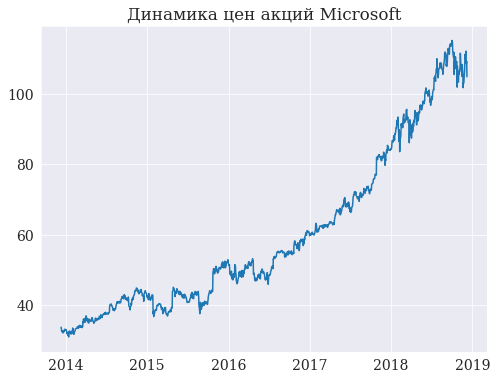

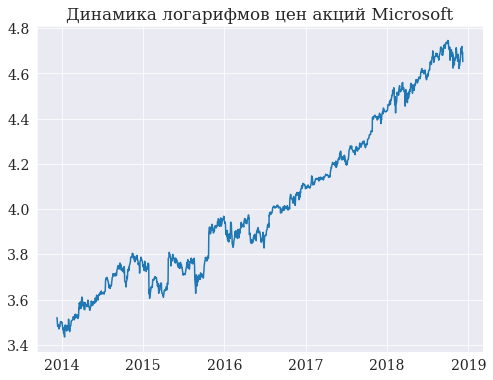

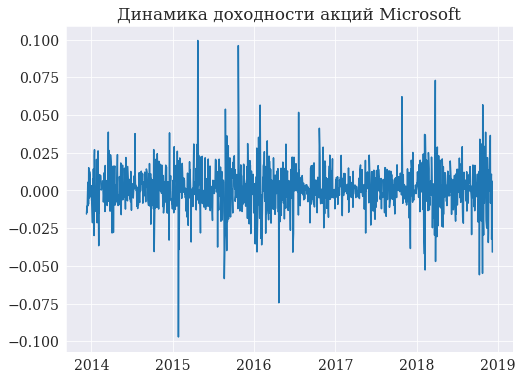

<Figure size 720x432 with 0 Axes>

In [16]:
plt.figure(figsize=(8,6))
plt.plot(msft['Date'],msft['Adj Close'])
plt.title(u'Динамика цен акций Microsoft')

plt.figure(figsize=(8,6))
plt.plot(msft['Date'],np.log(msft['Adj Close']))
plt.title(u'Динамика логарифмов цен акций Microsoft')

plt.figure(figsize=(8,6))
plt.plot(msft['Date'],msft['Log_ret_MSFT'])
plt.title(u'Динамика доходности акций Microsoft')
plt.show()
plt.gcf().clear()

### 1. Проверка временного ряда на стационарность ($\alpha=0.05$)

###  Модель авторегрессии - скользящего среднего корректно применять только к стационарным временным рядам. Стандартным критерием, используемым для проверки временного ряда на стационарность, явяляется критерий  Дикей-Фуллера (ADF - augmented Dickey-Fuller). В основе критерия лежит проверка значимости коэффициентов авторегрессии. Для данного критерия существуют специальные таблицы.

### Проведем исследование стационарности для логарифмов цен и логарифмической доходности. Нулевая гипотеза состоит в том, что  процесс носит нестационарный характер. Говоря математическим языком - корни характеристического уравнения авторегрессионной модели лежат вунтри единичного круга. 

In [17]:
tsa.stattools.adfuller(np.log(msft['Adj Close']),maxlag=10)
### логарифмы цен

(-0.10399823306438985,
 0.9490388349652014,
 8,
 1249,
 {'1%': -3.4355964295197743,
  '5%': -2.863856825923603,
  '10%': -2.5680035060041626},
 -7059.134393996628)

In [18]:
tsa.stattools.adfuller(msft['Log_ret_MSFT'],maxlag=10)
### логарифмическая доходность

(-15.043751660747319,
 9.51017028441337e-28,
 7,
 1250,
 {'1%': -3.435592223709696, '5%': -2.8638549702604803, '10%': -2.56800251776},
 -7061.125098359102)

### В приведенных результатах работы теста важными являются первые два элемента: само значение критерия и p-value. В случае логарифмов цен гипотеза об отсутствии стационарности принимается. В случае логарифмической доходности - гипотеза отвергается. Это означает, что для построения модели авторгерссии - скользящего среднего необходимо взять первые разности логарифмов цен (что и есть логарифмическая доходность).

### Определение порядков авторегресии и скользящего среднего

### Порядок процесса можно предварительно определить с помощью графиков авткорреляции и частной автокорреляция. Для этого построим указанные графики для стационарного процесса логарифмической доходности.

### 1. Значимые коэффициенты автокорреляции определяют порядок скользящего среднего
### 2. Значимые коэффициенты частной автокорреляции определяют порядок авторегрессии

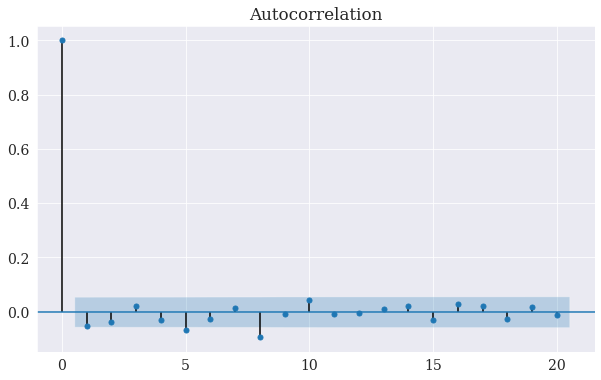

In [19]:
fig=tsaplots.plot_acf(msft['Log_ret_MSFT'],lags=20)

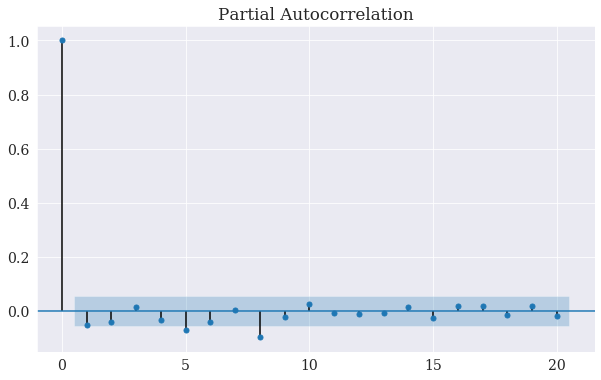

In [20]:
fig=tsaplots.plot_pacf(msft['Log_ret_MSFT'],lags=20)

### 2. Построение модели ARIMA 

###  В рассматриваемом случае нет возможности однозначно идентифицировать порядок модели только исходя из графиков. Обращает на себя внимание значимость коэффициентов для лаг 8. Реализуем простой цикл перебора параметров AR и MA.

In [21]:
d=1 # порядок интеграции, берем первые разности
l=list()

### Т.к. алгоритм расчета параметров модели может выдавать ошибку в случае несходимости, применем специальную конструкцию try - except, позволяющую обрабатывать исключения.

In [22]:
for i in range(0,4):
    for j in range(0,4):
        flag=True
        print('ARIMA({},{},{})'.format(i,d,j))
        try:
            model=tsa.arima_model.ARIMA(np.log(msft['Adj Close']),order=(i,d,j))
            res=model.fit()
        except:
            flag=False                                                       
            pass
        if (flag):
            l.append((i,j,res.bic))

ARIMA(0,1,0)
ARIMA(0,1,1)
ARIMA(0,1,2)
ARIMA(0,1,3)
ARIMA(1,1,0)
ARIMA(1,1,1)
ARIMA(1,1,2)
ARIMA(1,1,3)
ARIMA(2,1,0)
ARIMA(2,1,1)
ARIMA(2,1,2)
ARIMA(2,1,3)
ARIMA(3,1,0)
ARIMA(3,1,1)
ARIMA(3,1,2)
ARIMA(3,1,3)


In [23]:
l # первое число - порядок AR, второе число - порядок MA, третье число - BIC

[(0, 0, -7098.367218259176),
 (0, 1, -7094.979022210623),
 (0, 2, -7089.771258842741),
 (0, 3, -7082.775318828408),
 (1, 0, -7094.681191395785),
 (1, 1, -7096.496863485919),
 (1, 2, -7090.441107335922),
 (1, 3, -7083.796424620207),
 (2, 0, -7089.758081606257),
 (2, 1, -7090.389045864502),
 (2, 2, -7082.827844645201),
 (2, 3, -7077.655332823646),
 (3, 0, -7082.942938713351),
 (3, 1, -7076.006480395658),
 (3, 2, -7076.795973642895),
 (3, 3, -7072.920298688946)]

###  Для целей задания ограничимся самой простой моделью порядка (1,1,1), т.е. моделью авторегрессии первого порядка и скользящего среднего первого порядка, построенную по первым разностям.

### $\Delta y_t=\phi_0+\phi_1\Delta y_{t-1}+\varepsilon_t-\theta_1\varepsilon_{t-1}$

In [24]:
model_1=tsa.arima_model.ARIMA(np.log(msft['Adj Close']),order=(1,1,1))

In [25]:
results_1=model_1.fit()

In [26]:
print(results_1.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                 1257
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3562.521
Method:                       css-mle   S.D. of innovations              0.014
Date:                Thu, 07 May 2020   AIC                          -7117.043
Time:                        12:26:07   BIC                          -7096.497
Sample:                             1   HQIC                         -7109.321
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0009      0.000      3.723      0.000       0.000       0.001
ar.L1.D.Adj Close     0.8727      0.137      6.391      0.000       0.605       1.140
ma.L1.D.Adj Close    -0.

### Остатки модели ARIMA должны быть процессом "белого шума" (отсутствует автокорреляция)

### Для проверки гипотезы, связанной с присутствием в остатках автокорреляции будем использовать тест Льюнга-Бокса. Данный тест  основан на  коэффициентах автокорреляции, рассчитываемых для разного количества лагов (смещений). Таким образом данный тест позволяет идентифицировать автокорреляцию остатков более высоких порядков.

In [27]:
test.acorr_ljungbox(results_1.resid)[0][0:10]
### значение статистики Льюнга-Бокса

array([ 0.18376968,  0.20441908,  3.17818108,  3.21539134,  5.7483381 ,
        5.82026216,  6.881825  , 13.67727569, 13.74339688, 17.69843984])

In [28]:
test.acorr_ljungbox(results_1.resid)[1][0:10]
#  pvalue статистики Льюнга-Бокса

array([0.66815345, 0.90284035, 0.36496058, 0.52244857, 0.33148193,
       0.44362283, 0.44128717, 0.09057469, 0.13175035, 0.06026864])

### Общий вывод: Модель ARIMA (1,1,1), в целом, адекватно описывает исследуемый процесс. Коэффиценты AR  и MA меньше 1. Это говорит о том, что процесс имеет характер  "возврата к средней" (mean reversion). В частности, на основе данного процесса можно строить "статистические" арбитражные стратегии торговли. В противном случае речь идет о взрывной динамике, и процессом сложно управлять.

###  3. Построение модели GARCH

### Процесс GARCH строится на основе остатков модели ARIMA, т.е. отфильтрованных данных. Для идентификации кластеров волатильности используются графики квадрата остатков и ACF для квадрата остатков.

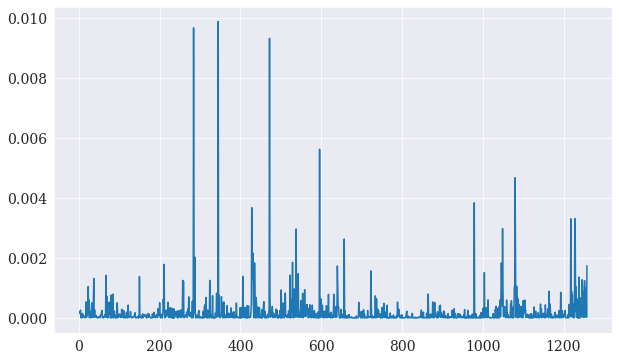

In [29]:
fig=(results_1.resid**2).plot()

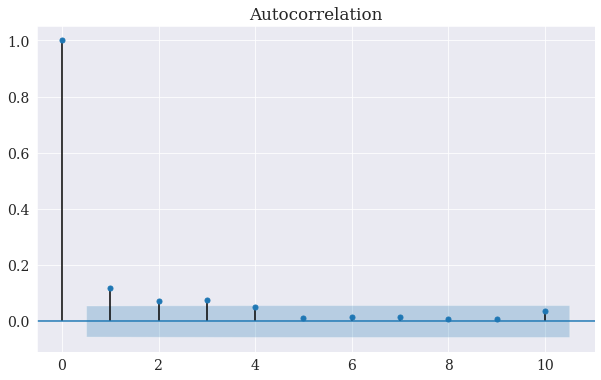

In [30]:
fig=tsaplots.plot_acf(results_1.resid**2,lags=10)

### С помощью  теста Льюнга-Бокса проверим ряд квадратов остатков на наличие автокорреляции.

In [31]:
test.acorr_ljungbox(results_1.resid**2)[1][0:10]
###  pvalue статистики Льюнга-Бокса

array([2.43653185e-05, 6.30693361e-06, 8.93151653e-07, 6.60311827e-07,
       1.97250849e-06, 4.96828446e-06, 1.15012639e-05, 2.63180902e-05,
       5.66088869e-05, 6.28304613e-05])

### Значение теста показывает, что в ряде квадрата остатков присутствует автокорреляция, следовательно в исследовани необходимо использовать модель GARCH.

### Для построения модели воспользуемся библиотекой ARCH. Построим модель GARCH по двум наборам данных - по исходным данным и по остаткам модели ARIMA. Если в качестве объекта исследования рассматриваются исходные данные, необходимо первоначально построить модель доходности.

### Ограничимся простой моделью GARCH(1,1), имеющий следующий вид:

### $\varepsilon_t=\sigma_t\epsilon_t$
### ${\sigma^2}_t=\omega+\alpha_1{\varepsilon^2}_{t-1}+\beta_1{\sigma^2}_{t-1}$

### 3.1. Модель по исходным данным

### Моделирование доходности - Zero Mean

In [32]:
zm=ZeroMean(msft['Log_ret_MSFT'])

In [33]:
zm.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Zero Mean - Constant Variance Model Results                  
==============================================================================
Dep. Variable:           Log_ret_MSFT   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:          Constant Variance   Log-Likelihood:                3556.56
Distribution:                  Normal   AIC:                          -7111.12
Method:            Maximum Likelihood   BIC:                          -7105.99
                                        No. Observations:                 1258
Date:                Thu, May 07 2020   Df Residuals:                     1257
Time:                        12:26:09   Df Model:                            1
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
sigma2     2.0506e-04  1.758e-05     11.666  1.908e-31 [1.706e-04,2.395e-04]
============================================================================

Covariance estimator: White's Heteroskedasticity Consistent Estimator
"""

In [34]:
zm.volatility=GARCH(p=1,q=1)

In [35]:
res_zm = zm.fit(update_freq=0, disp='off')

In [36]:
res_zm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:           Log_ret_MSFT   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                3608.28
Distribution:                  Normal   AIC:                          -7210.56
Method:            Maximum Likelihood   BIC:                          -7195.15
                                        No. Observations:                 1258
Date:                Thu, May 07 2020   Df Residuals:                     1255
Time:                        12:26:09   Df Model:                            3
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.4848e-05  4.182e-06     10.725  7.810e-27 [3.665e-05,5.304e-05]
alpha[1]       0.1458  4.323e-02      3.373  7.444e-04   [6.107e-02,  0.231]
beta[1]        0.6355  4.513e-02     14.081  5.004e-45     [  0.547,  0.724]
============================================================================

Covariance estimator: robust
"""

### Модель не дает в полной мере адекватного результата, т.к. отсутсвует сходимость алгоритма.

### Моделирование доходности - Constant Mean

### $r_t=\mu+\varepsilon_t$

In [37]:
cm=ConstantMean(msft['Log_ret_MSFT'])

In [38]:
cm.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Constant Mean - Constant Variance Model Results                
==============================================================================
Dep. Variable:           Log_ret_MSFT   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:          Constant Variance   Log-Likelihood:                3558.98
Distribution:                  Normal   AIC:                          -7113.96
Method:            Maximum Likelihood   BIC:                          -7103.69
                                        No. Observations:                 1258
Date:                Thu, May 07 2020   Df Residuals:                     1256
Time:                        12:26:09   Df Model:                            2
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         8.8739e-04  4.030e-04      2.202  2.766e-02 [9.759e-05,1.677e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
sigma2     2.0428e-04  1.754e-05     11.649  2.318e-31 [1.699e-04,2.386e-04]
============================================================================

Covariance estimator: White's Heteroskedasticity Consistent Estimator
"""

In [39]:
cm.volatility=GARCH(p=1,q=1)

In [40]:
res_cm = cm.fit(update_freq=0, disp='off')

In [41]:
res_cm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:           Log_ret_MSFT   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                3611.09
Distribution:                  Normal   AIC:                          -7214.17
Method:            Maximum Likelihood   BIC:                          -7193.62
                                        No. Observations:                 1258
Date:                Thu, May 07 2020   Df Residuals:                     1254
Time:                        12:26:09   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.0988e-03  3.495e-04      3.144  1.667e-03 [4.138e-04,1.784e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.1283e-05  1.169e-05      5.242  1.591e-07 [3.837e-05,8.420e-05]
alpha[1]       0.2000  5.587e-02      3.580  3.438e-04   [9.050e-02,  0.310]
beta[1]        0.5000  9.040e-02      5.531  3.187e-08     [  0.323,  0.677]
============================================================================

Covariance estimator: robust
"""

###  Проверим остатки модели на наличие автокорреляции

In [42]:
test.acorr_ljungbox(res_cm.resid)[0][0:10]
### значение статистики Льюнга-Бокса

array([ 3.30751421,  5.1478247 ,  5.72912256,  7.03154322, 12.98247316,
       13.95491083, 14.16999922, 25.14715226, 25.20722743, 27.63260316])

In [43]:
test.acorr_ljungbox(res_cm.resid)[1][0:10]
###  pvalue статистики Льюнга-Бокса

array([0.06896374, 0.0762367 , 0.12555901, 0.13423067, 0.02354357,
       0.03014391, 0.04823905, 0.00146775, 0.0027503 , 0.00206649])

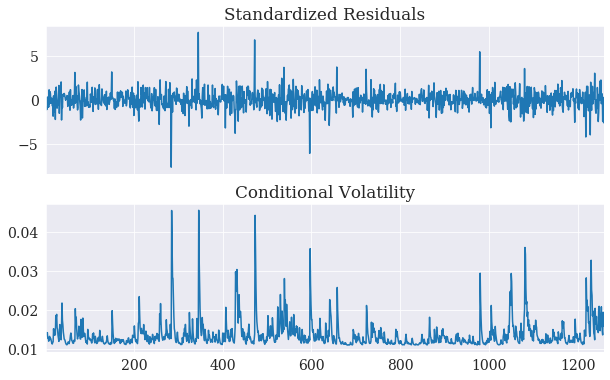

In [44]:
fig=res_cm.plot()

###  В первых лагах автокорреляция отсутсвует, однако  для более отдаленных лагов можно  отметить наличие внутренней зависимости. По этой причине однозначного вывода об адекватности модели сделать нельзя.

### Моделирование доходности - AR

In [45]:
ar=ARX(msft['Log_ret_MSFT'],lags=[1]) # моделирование доходности с помощью процесса AR(1)

In [46]:
ar.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     AR - Constant Variance Model Results                     
==============================================================================
Dep. Variable:           Log_ret_MSFT   R-squared:                       0.003
Mean Model:                        AR   Adj. R-squared:                  0.002
Vol Model:          Constant Variance   Log-Likelihood:                3557.98
Distribution:                  Normal   AIC:                          -7109.97
Method:            Maximum Likelihood   BIC:                          -7094.56
                                        No. Observations:                 1257
Date:                Thu, May 07 2020   Df Residuals:                     1254
Time:                        12:26:11   Df Model:                            3
                                   Mean Model                                  
===============================================================================
                    coef    std err          t      P>|t|      95.0% Conf. Int.
-------------------------------------------------------------------------------
Const         9.4800e-04  4.089e-04      2.318  2.042e-02 [1.466e-04,1.749e-03]
Log_...SFT[1]    -0.0516  4.076e-02     -1.265      0.206   [ -0.131,2.832e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
sigma2     2.0368e-04  1.758e-05     11.584  4.985e-31 [1.692e-04,2.381e-04]
============================================================================

Covariance estimator: White's Heteroskedasticity Consistent Estimator
"""

In [47]:
ar.volatility=GARCH(p=1,q=1)

In [48]:
res_ar = ar.fit(update_freq=0, disp='off')

In [49]:
res_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:           Log_ret_MSFT   R-squared:                       0.002
Mean Model:                        AR   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                3613.30
Distribution:                  Normal   AIC:                          -7216.60
Method:            Maximum Likelihood   BIC:                          -7190.91
                                        No. Observations:                 1257
Date:                Thu, May 07 2020   Df Residuals:                     1252
Time:                        12:26:11   Df Model:                            5
                                   Mean Model                                  
===============================================================================
                    coef    std err          t      P>|t|      95.0% Conf. Int.
-------------------------------------------------------------------------------
Const         1.1351e-03  3.569e-04      3.180  1.471e-03 [4.356e-04,1.835e-03]
Log_...SFT[1]    -0.0225  4.903e-02     -0.458      0.647   [ -0.119,7.362e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.6373e-05  3.215e-06     11.314  1.120e-29 [3.007e-05,4.267e-05]
alpha[1]       0.2103  8.599e-02      2.446  1.445e-02   [4.178e-02,  0.379]
beta[1]        0.6405  5.497e-02     11.652  2.245e-31     [  0.533,  0.748]
============================================================================

Covariance estimator: robust
"""

###  Проверим остатки модели на наличие автокорреляции

In [50]:
test.acorr_ljungbox(res_ar.resid.dropna())[1][0:10]
###  pvalue статистики Льюнга-Бокса

array([0.27422399, 0.20338605, 0.30402484, 0.28679045, 0.04485325,
       0.05324046, 0.08408791, 0.00295812, 0.00531334, 0.00386913])

###  В первых лагах автокорреляция отсутсвует, однако  для более отдаленных лагов можно  отметить наличие внутренней зависимости. По этой причине однозначного вывода об адекватности модели сделать нельзя.

### Расчет безусловной волатильности и устойчивости (persistence) возмущения

In [51]:
res_cm.params

mu          0.001099
omega       0.000061
alpha[1]    0.200000
beta[1]     0.500000
Name: params, dtype: float64

In [52]:
res_cm.params[1]/(1-res_cm.params[2]-res_cm.params[3]) 

0.00020427664477801392

In [53]:
res_cm.params[2]+res_cm.params[3]

0.7000000525647193

### 3.2. Модель по остаткам ARIMA 

In [54]:
cm_1=ConstantMean(results_1.resid) # модель постоянной средней

In [55]:
cm_1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Constant Mean - Constant Variance Model Results                
==============================================================================
Dep. Variable:                   None   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:          Constant Variance   Log-Likelihood:                3562.53
Distribution:                  Normal   AIC:                          -7121.07
Method:            Maximum Likelihood   BIC:                          -7110.79
                                        No. Observations:                 1257
Date:                Thu, May 07 2020   Df Residuals:                     1255
Time:                        12:26:11   Df Model:                            2
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -1.8960e-05  4.011e-04 -4.727e-02      0.962 [-8.051e-04,7.672e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
sigma2     2.0221e-04  1.762e-05     11.475  1.759e-30 [1.677e-04,2.368e-04]
============================================================================

Covariance estimator: White's Heteroskedasticity Consistent Estimator
"""

In [56]:
cm_1.volatility=GARCH(p=1,q=1)

In [57]:
res_cm_1 = cm_1.fit(update_freq=0, disp='off')

In [58]:
res_cm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:                3617.77
Distribution:                  Normal   AIC:                          -7227.53
Method:            Maximum Likelihood   BIC:                          -7206.99
                                        No. Observations:                 1257
Date:                Thu, May 07 2020   Df Residuals:                     1253
Time:                        12:26:12   Df Model:                            4
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         2.9955e-04  3.495e-04      0.857      0.391 [-3.855e-04,9.846e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.7826e-05  3.479e-06     10.873  1.545e-27 [3.101e-05,4.464e-05]
alpha[1]       0.2114  8.413e-02      2.513  1.197e-02   [4.652e-02,  0.376]
beta[1]        0.6311  5.635e-02     11.201  4.022e-29     [  0.521,  0.742]
============================================================================

Covariance estimator: robust
"""

In [59]:
test.acorr_ljungbox(res_cm_1.resid)[1][0:20]
###  pvalue статистики Льюнга-Бокса

array([0.66815345, 0.90284035, 0.36496058, 0.52244857, 0.33148193,
       0.44362283, 0.44128717, 0.09057469, 0.13175035, 0.06026864,
       0.08823153, 0.12327809, 0.1487106 , 0.15420266, 0.17461728,
       0.16318278, 0.17822653, 0.19913264, 0.22418479, 0.26792174])

###  Можно сделать вывод об отсутствии автокорреляции остатков модели GARCH.

### Общий вывод - модель ARIMA-GARCH может быть использована для моделирования рассматриваемого временного ряда.

## 3. Нахождение рыночной β и тестирование гипотезы CAPM

### Классическая версия модели CAPM предполагает отсутсвие в регрессионной модели свободного члена или в инвестиционной терминологии $\alpha$.  Это означает, что рассматриваемый актив не может систематически "обыграть" рынок. Таким образом, основной акцент делается на показателе рыночной $\beta$.

### $ER_i=R_f+\beta_i(ER_m-R_f)$

### Модель CAPM на основе индекса SP500 (дневные данные)

In [60]:
sp=pd.read_csv('/home/maxime/Documentos/Econometrics/')
# загрузка данных по динамике индекса SP500 

In [61]:
sp['Date']=pd.to_datetime(sp['Date'],format='%Y-%m-%d')
###  преобразование поля в формат даты

In [62]:
sp['Log_ret_SP']=np.log(sp['Adj Close'])-np.log(sp['Adj Close'].shift(1))
### расчет логарифмической доходности

In [63]:
sp.drop([0],axis=0,inplace=True)
### удаление первого наблюдения со значением nan

In [64]:
port=sp[['Date','Log_ret_SP']].merge(msft[['Date','Log_ret_MSFT']],left_on=['Date'],right_on=['Date'])
### объединение акций и индекса в один dataframe

In [65]:
port.columns=['Date','Log_ret_SP','Log_ret_MSFT']

In [66]:
port.tail()

,Date,Log_ret_SP,Log_ret_MSFT
1253,2018-11-30,0.008138,0.006333
1254,2018-12-03,0.010882,0.010763
1255,2018-12-04,-0.032900,-0.032368
1256,2018-12-06,-0.001523,0.006155
1257,2018-12-07,-0.023596,-0.040845


In [67]:
results_3=smf.ols('Log_ret_MSFT ~ Log_ret_SP',data=port).fit()
### простая линейная регрессия

In [68]:
print(results_3.summary())

                            OLS Regression Results                            
Dep. Variable:           Log_ret_MSFT   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     1314.
Date:                Thu, 07 May 2020   Prob (F-statistic):          1.61e-197
Time:                        12:26:12   Log-Likelihood:                 4009.4
No. Observations:                1258   AIC:                            -8015.
Df Residuals:                    1256   BIC:                            -8004.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0005      0.000      1.814      0.0

### Проверка выполнения условия гомоскедастичности с помощью критерия Бреуша-Пагана

In [69]:
lm,lm_value,fvalue,f_pvalue=diagnostic.het_breuschpagan(results_3.resid,results_3.model.exog)

In [70]:
print('lm %.4f,lm_pvalue %.4f,fvalue %.4f,f_pvalue %.4f'%(lm,lm_value,fvalue,f_pvalue))

lm 0.0565,lm_pvalue 0.8121,fvalue 0.0564,f_pvalue 0.8123


### С учетом значения p-value гипотеза об отсутствии гомоскедастичности принимается

### Проверка наличия структурных сдвигов

### Структурный сдвиг означает, что процесс притерпевает определенные изменения, которые могут сильно сказаться на параметрах модели. В случае наличия структурного сдвга целесооборазно использовать не одну, а две модели - до сдвига и после. Проверка гипотезы об отсутствии структурных сдвигов осуществвляется с помощью ряда  критериев, самым популярным из которых в эконометрике остается тест Чоу. В statsmodels реализованы критерий кумулятивной суммы (CUSUM)  и критерий Хансена. 

In [71]:
diagnostic.breaks_cusumolsresid(results_3.resid)[0:2]

(0.7417390915141883, 0.6410867229055677)

In [72]:
diagnostic.breaks_hansen(results_3)[0:2]

(2.409549598147163,
 array([( 2, 1.9 ), ( 6, 3.75), (15, 3.75), (19, 4.52)],
       dtype=[('nobs', '<i8'), ('crit', '<f8')]))

### С учетом значения критериев и p-value гипотеза об отсутствии структурного сдвига принимается

### Общие выводы:
### 1. Уравнение значимо, что подтверждается t и F критериями.
### 2. Показатель $\beta$ = 1.26, это говорит о том, что акции Microsoft растут (и, соответственно, падают) сильнее рынка акций, включающего все отрасли.
### 3. Показатель $\alpha$ статистчически незначимо отличается от 0, что согласуется с моделью CAPM

### Модель CAPM на основе индекса NASDAQ (дневные данные)

In [73]:
nasdaq=pd.read_csv('/home/maxime/Documentos/Econometrics/^IXIC.csv')

In [74]:
nasdaq['Date']=pd.to_datetime(nasdaq['Date'],format='%Y-%m-%d')
###  преобразование поля в формат даты

In [75]:
nasdaq['Log_ret_Nasdaq']=np.log(nasdaq['Adj Close'])-np.log(nasdaq['Adj Close'].shift(1))

In [76]:
nasdaq.drop([0],axis=0,inplace=True)

In [77]:
nasdaq.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Log_ret_Nasdaq
1,2013-12-12,4004.750000,4013.540039,3993.570068,3998.399902,3998.399902,1893270000,-0.001352
2,2013-12-13,4015.530029,4017.449951,3992.290039,4000.979980,4000.979980,1615340000,0.000645
3,2013-12-16,4019.370117,4043.000000,4019.139893,4029.520020,4029.520020,1943830000,0.007108
4,2013-12-17,4028.879883,4034.689941,4011.580078,4023.679932,4023.679932,1861130000,-0.001450
5,2013-12-18,4024.669922,4070.379883,3979.590088,4070.060059,4070.060059,2178330000,0.011461


In [78]:
port=port.merge(nasdaq[['Date','Log_ret_Nasdaq']],left_on=['Date'],right_on=['Date'])

In [79]:
port.head()

,Date,Log_ret_SP,Log_ret_MSFT,Log_ret_Nasdaq
0,2013-12-12,-0.003778,-0.010424,-0.001352
1,2013-12-13,-0.000101,-0.014342,0.000645
2,2013-12-16,0.006300,0.005437,0.007108
3,2013-12-17,-0.003106,-0.010081,-0.001450
4,2013-12-18,0.016511,0.001642,0.011461


In [80]:
results_4=smf.ols('Log_ret_MSFT ~ Log_ret_Nasdaq',data=port).fit()
### простая линейная регрессия

In [81]:
print(results_4.summary())

                            OLS Regression Results                            
Dep. Variable:           Log_ret_MSFT   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     1643.
Date:                Thu, 07 May 2020   Prob (F-statistic):          2.87e-230
Time:                        12:26:13   Log-Likelihood:                 4079.3
No. Observations:                1256   AIC:                            -8155.
Df Residuals:                    1254   BIC:                            -8144.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0004      0.000      1.

### Общие выводы:
### 1. Уравнение значимо, что подтверждается t и F критериями.
### 2. Показатель $\beta$ = 1.10, это говорит о том, что акции Microsoft растут (и, соответственно, падают) быстрее рынка технологических акций. 
### 3. Показатель $\alpha$ статистчически незначимо отличается от 0, что согласуется с моделью CAPM

### Модель CAPM на основе индекса SP500 (месячные данные)

In [82]:
port['Year']=port['Date'].dt.year

In [83]:
port['Month']=port['Date'].dt.month

### Для преобразования дневных доходностей в месячные доходности воспользуемся удобным свойством логарифма и просуммируем дневные доходности по каждому месяцу

In [84]:
port_monthly=port.groupby(['Year','Month'])[['Log_ret_SP','Log_ret_MSFT','Log_ret_Nasdaq']].sum()
### преобразование дневных доходностей в месячные доходности

In [85]:
port_monthly.head()

Log_ret_SP  Log_ret_MSFT  Log_ret_Nasdaq
Year Month                                          
2013 12       0.036439     -0.005332        0.042249
2014 1       -0.036231      0.011429       -0.017562
     2        0.042213      0.019815        0.048569
     3        0.006908      0.067617       -0.025658
     4        0.006182     -0.014498       -0.020312

In [86]:
np.log(float(msft[msft.Date=='2014-01-31']['Adj Close'])/float(msft[msft.Date=='2013-12-31']['Adj Close']))
### проверка формулы получения месячной доходности

0.011428544757738605

In [87]:
results_5=smf.ols('Log_ret_MSFT ~ Log_ret_SP',data=port_monthly).fit()
### простая линейная регрессия

In [88]:
print(results_5.summary())

                            OLS Regression Results                            
Dep. Variable:           Log_ret_MSFT   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     38.48
Date:                Thu, 07 May 2020   Prob (F-statistic):           5.94e-08
Time:                        12:26:13   Log-Likelihood:                 103.46
No. Observations:                  61   AIC:                            -202.9
Df Residuals:                      59   BIC:                            -198.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0109      0.006      1.850      0.0

### Выводы аналогичны предыдущим моделям

### 1. Выбрать актив и загрузить из внешних источников исторические котировки(например, Yahoo finance)
### 2. Провести предварительный анализ временного ряда , проверить гипотезу стационарности
### 3. Построить модель ARIMA-GARCH и сделать краткие выводы
### 4. Построить модель CAPM по рыночным данным, получить $\beta$, оценить значимость $\alpha$, сравнить полученный показатель $\beta$ с данными из общедоступных источников информации (например, Yahoo, Reuters)